ODE challenge for the duffing oscillator with noisy data. Goes through solving it manually and then with VBMC.

## SOLUTION: ODE challenge 1

In [30]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import odeint # Import odeint
import numpy as np
from pyvbmc import VBMC
import scipy.stats as scs

First read in data:

In [31]:
data = pd.read_csv("/Users/gracerojo/Downloads/duffing_oscillator_data_noisy.csv") # CHANGE
#this is definitely in some other folder now

#t_data = data["timestamp"]
#x_data = data["value2"]

t_data = data["time"]
x_data = data["data"]

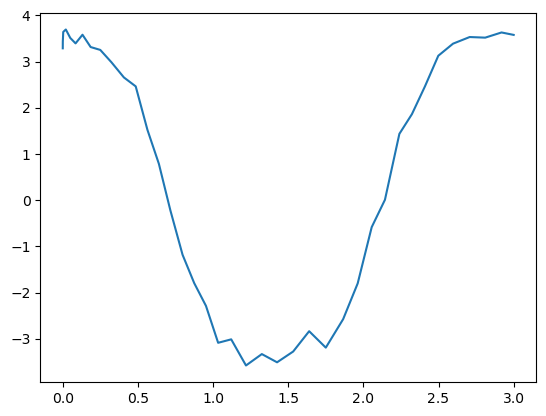

In [32]:
plt.plot(t_data,x_data)
plt.show()

## Now using the equation:

$$\ddot{x} = -\beta x - \epsilon x^3$$

In [33]:
def diffyqs(X, t, epsilon,beta): # fn to pass to solver (essentially identical to the Julia solver but indexed different)
    x, vx = X[0], X[1]
    dx = vx
    dv = -beta*x - epsilon * x**3
    return [dx, dv]

In [34]:
# initial conditions (could get these from data)
x0_1 = [0.0, 3.5]

# use time data as time array for solver
t = t_data

# range of values of epsiilon to sweep over
epsilons = np.arange(0.5,5,0.5)

# empty list to store solutions
sols = []

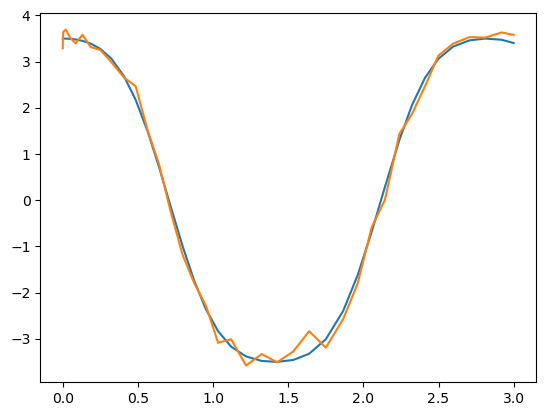

In [35]:
epsilon = 1.5
beta = epsilon

sol = odeint(diffyqs, x0_1, t, args=(epsilon,beta))

plt.plot(t,sol.T[1])
plt.plot(t,x_data)
plt.show()

In [36]:
# sweep over each value of epsilon and do numerical solution for each
for epsilon in epsilons:
    sols.append(odeint(diffyqs, x0_1, t, args=(epsilon,beta)))

Now that we have results, let's visualize them:

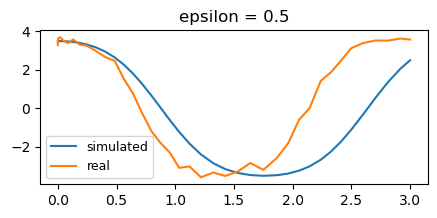

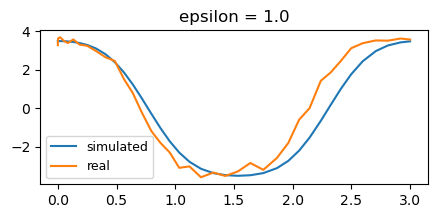

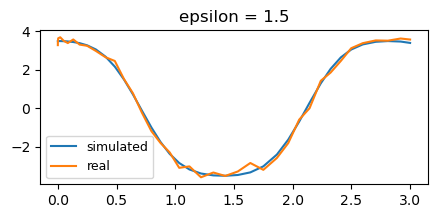

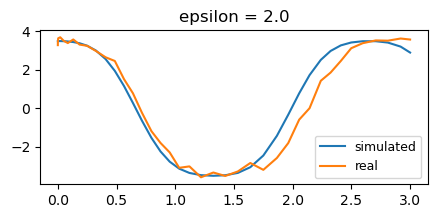

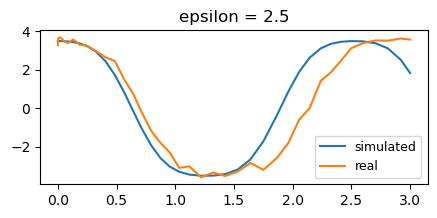

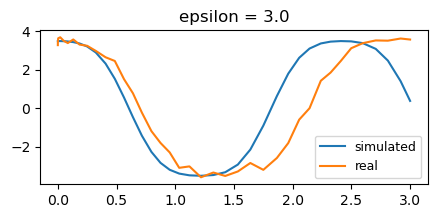

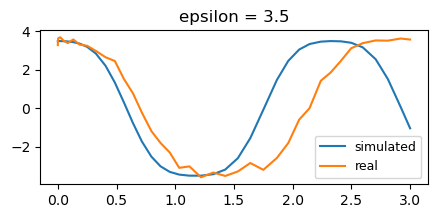

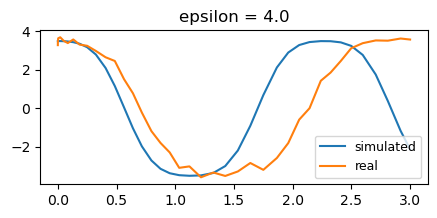

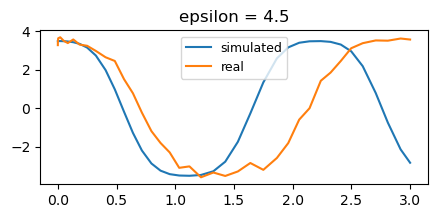

In [37]:
for i, sol in enumerate(sols):
    plt.figure(figsize = (5,2))
    plt.plot(t,sol.T[1], label = "simulated")
    plt.plot(t_data,x_data, label = 'real')
    plt.title('epsilon = ' + str(epsilons[i]))
    plt.legend(fontsize = 9)
    plt.show()

It looks like $\varepsilon = 1.5$ is a good choice. Let's write some code to be a bit more precise about this. We can add up the absolute value of the difference between the simulated and real trajectories to get the cumulative difference between them. The trajectory that minimizes this value will correspond to the best choice of $\varepsilon$

In [11]:
differences = []
for i, sol in enumerate(sols):
    differences.append(sum(np.abs(sol.T[1] - x_data)))

print("the best choice of epsilon is:", epsilons[np.argmin(differences)])

the best choice of epsilon is: 1.5


In [27]:
def log_likelihood(theta):
    epsilon, beta = theta
    sigma = 0.2
    sol = odeint(diffyqs, x0_1, t, args=(epsilon,beta))
    return np.sum(np.log(1/(sigma* (2*np.pi)**0.5)) - (0.5/sigma**2) * (sol.T[1] - x_data)**2)

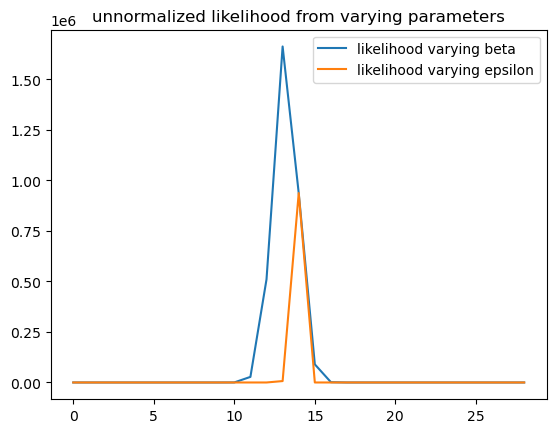

In [38]:
vals = []
for a in np.arange(0.1,3,0.1):
    vals.append(log_likelihood((a,1.5)))

vals2 = []
for a in np.arange(0.1,3,0.1):
    vals2.append(log_likelihood((1.5,a)))

plt.plot(np.exp(vals2),label = "likelihood varying beta")
plt.plot(np.exp(vals), label = "likelihood varying epsilon")
plt.title("unnormalized likelihood from varying parameters")
plt.legend()
plt.show()

^^ this doesen't seem reasonable to me

In [18]:
D = 2  # We consider a 2-D problem

# def log_likelihood(theta):
#     """D-dimensional Rosenbrock's banana function."""
#     theta = np.atleast_2d(theta)

#     x, y = theta[:, :-1], theta[:, 1:]

    
#     return -np.sum((x**2 - y) ** 2 + (x - 1) ** 2 / 100, axis=1)

prior_mu = np.zeros((1, D))
prior_std = 0.01 * np.ones((1, D))

def log_prior(x):
    """Independent normal prior."""
    return np.sum(scs.norm.logpdf(x, prior_mu, prior_std))

def log_joint(x):
    """log-density of the joint distribution."""
    return log_likelihood(x) + log_prior(x)

LB = np.full((1, D), -5.0)  # Lower bounds
UB = np.full((1, D), 5.0)  # Upper bounds

PLB = prior_mu - prior_std  # Plausible lower bounds
PUB = prior_mu + prior_std  # Plausible upper bounds

x0 =np.copy(prior_mu) #  0.02 * np.ones((1, D)) #

vbmc = VBMC(log_joint, x0, LB, UB, PLB, PUB)

In [19]:
vp, results = vbmc.optimize()

Beginning variational optimization assuming EXACT observations of the log-joint.
 Iteration  f-count    Mean[ELBO]    Std[ELBO]    sKL-iter[q]   K[q]  Convergence  Action
     0         10       -6026.15      3064.29     62572.13        2        inf     start warm-up
     1         15       -6824.72        80.38       857.94        2        inf     
     2         20       -6583.42        41.97       137.26        2   4.18e+03     
     3         25       -6462.04         0.06        23.96        2        970     
     4         30       -6322.11         0.25        51.77        2   1.69e+03     
     5         35       -6181.96         0.49        87.02        2   2.52e+03     
     6         40       -6096.89         0.29        68.62        2    1.9e+03     
     7         45       -6052.02         0.13        37.17        2   1.03e+03     
     8         50       -6023.29         0.06        25.83        2        705     
     9         55       -6007.27         0.03        14.49  

/Users/gracerojo/opt/anaconda3/envs/bpe/lib/python3.11/site-packages/pyvbmc/vbmc/active_sample.py:584: UserWarning: Rank-one update of Cholesky factor unstable for posterior 0. Reverting to full update.
  gp.update(xnew, ynew, compute_posterior=True)


    11         65       -5991.66         0.01         6.27        2        166     
    12         70       -5988.73         0.01         4.23        2        110     


/Users/gracerojo/opt/anaconda3/envs/bpe/lib/python3.11/site-packages/pyvbmc/vbmc/active_sample.py:584: UserWarning: Rank-one update of Cholesky factor unstable for posterior 4. Reverting to full update.
  gp.update(xnew, ynew, compute_posterior=True)


    13         75       -5987.49         0.01         2.32        2       58.8     


/Users/gracerojo/opt/anaconda3/envs/bpe/lib/python3.11/site-packages/pyvbmc/vbmc/active_sample.py:584: UserWarning: Rank-one update of Cholesky factor unstable for posterior 2. Reverting to full update.
  gp.update(xnew, ynew, compute_posterior=True)
/Users/gracerojo/opt/anaconda3/envs/bpe/lib/python3.11/site-packages/pyvbmc/vbmc/active_sample.py:584: UserWarning: Rank-one update of Cholesky factor unstable for posterior 1. Reverting to full update.
  gp.update(xnew, ynew, compute_posterior=True)
/Users/gracerojo/opt/anaconda3/envs/bpe/lib/python3.11/site-packages/pyvbmc/vbmc/active_sample.py:584: UserWarning: Rank-one update of Cholesky factor unstable for posterior 7. Reverting to full update.
  gp.update(xnew, ynew, compute_posterior=True)


    14         80       -5986.97         0.00         0.67        2       17.4     
    15         85       -5986.90         0.01         0.11        2       2.74     
    16         90       -5986.90         0.00         0.01        2      0.346     
    17         95       -5986.90         0.00         0.00        2     0.0546     
    18        100       -5986.90         0.00         0.00        2     0.0672     end warm-up
    19        105       -5986.88         0.00         0.00        2      0.117     
    20        110       -5986.86         0.00         0.01        2      0.349     
    21        115       -5986.64         0.00         0.08        5       2.57     
    22        120       -5986.63         0.00         0.01        6      0.167     rotoscale, undo rotoscale
    23        125       -5986.61         0.00         0.00        9      0.109     
    24        130       -5986.60         0.00         0.00       12      0.125     
    25        135       -5986.60        

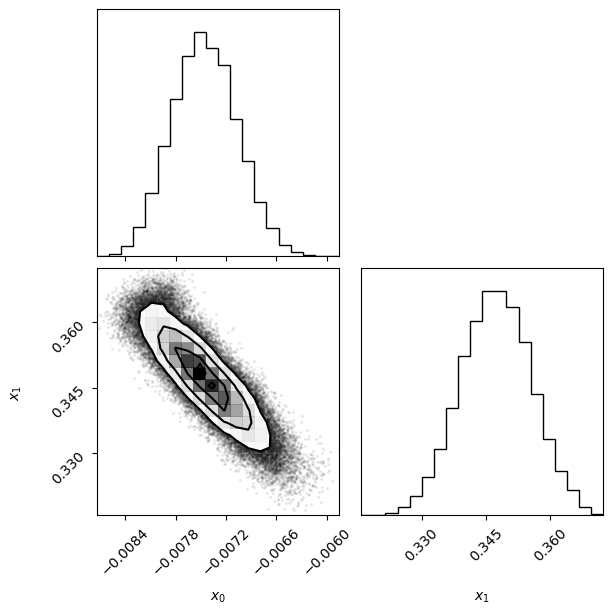

In [20]:
vp.plot();

In [28]:
# First, generate a large number of samples from the variational posterior:
n_samples = int(3e5)
Xs, _ = vp.sample(n_samples)

# Easily compute statistics such as moments, credible intervals, etc.
post_mean = np.mean(Xs, axis=0)  # Posterior mean
post_cov = np.cov(Xs.T)  # Posterior covariance matrix
print("The approximate posterior mean is:", post_mean)
print("The approximate posterior covariance matrix is:\n", post_cov)
print(Xs.mean())

The approximate posterior mean is: [-0.00745136  0.3472685 ]
The approximate posterior covariance matrix is:
 [[ 1.47045277e-07 -2.71441712e-06]
 [-2.71441712e-06  6.70151551e-05]]
0.16990856799856285


In [29]:
#lml_true = -2.272  # ground truth, which we know for this toy scenario

#print("The true log model evidence is:", lml_true)
print("The obtained ELBO is:", format(results["elbo"], ".3f"))
print("The obtained ELBO_SD is:", format(results["elbo_sd"], ".3f"))

The obtained ELBO is: -5986.601
The obtained ELBO_SD is: 0.000
